Imports

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

loading dataset

In [4]:
transform = transforms.Compose(
    # convert PIL to tensor
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
    # brings each pixel's RGB conponent to (-1,1) range

batch_size = 4 # 4 images processed at a time

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform) 
# gets the images and applies predefined transformation
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# loads 4 images at a time

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:21<00:00, 8.09MB/s] 


we can explore the dataset as well, the idea is to classify pixelated images of animals and some means of transport as the their respective labellings, its a labelled dataset with 10 classes

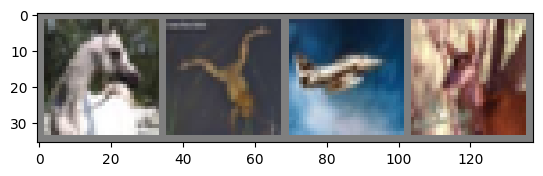

horse frog  plane deer 


In [6]:


def imshow(img):
    img = img / 2 + 0.5     # unnormalize to actually show the real pixel value
    npimg = img.numpy() # converting img pixels into numpy darray
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # transpose for correct orientation
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

looks good, now let's make the machine learn

In [9]:

class Net(nn.Module):
    def __init__(self):
        super().__init__() 
        self.conv1 = nn.Conv2d(3, 6, 5) 
        # layer 1: a convolution with 3 input channles (RGB), have 6 filters to extract features (6 feature maps),
        # each being 5 * 5 in dimension, this makes output from this layers 28 by 28 in dimension
        self.pool = nn.MaxPool2d(2, 2)
        # downsampling, i.e. reducing spatial dimension of kernel from 5 by 5 to 2 by 2 (max value), making output 14 by 14
        self.conv2 = nn.Conv2d(6, 16, 5) 
        # input to conv2: (6, 14, 14) dimension
        # another convolution with 6 feauture maps, now 16 feature maps with 5 by 5 kernels
        # output: [(16, 10, 10)]
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # fully connected layer with  16 feature maps of 5 by 5 as input, containing 120 neurons
        self.fc2 = nn.Linear(120, 84)
        # fully connected layer with 120 neurons as inputs, 84 as output
        self.fc3 = nn.Linear(84, 10)
        # final layer with 84 as input, and output to 10 class values


# the forward pass function uses the modules defined above to construct the neural network
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # first convolution, ReLU, maxPool
        
        x = self.pool(F.relu(self.conv2(x)))
        # second convolution, ReLu, maxPool
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # this makes 16 * 5 * 5 into one dimension of 400
        
        x = F.relu(self.fc1(x))
        # first linear layer, and then ReLU
        
        x = F.relu(self.fc2(x))
        # second Linear layer, then ReLU
        
        x = self.fc3(x)
        # final output layer with raw scores
        
        return x


net = Net() 

One thing so far slightly lost on me is the fact that the final scores are raw, but cross entropy needs 0-1 probabililty values. Maybe we will apply softmax within the loss function

In [10]:
criterion = nn.CrossEntropyLoss() 
# this CE Loss has to include Softmax within it, a quick google search confirmed that it does

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# regular SGD with batches of 4, ADAM learning method with momentum and supposedly backprop written into it


Now, for actual training loop

In [11]:
for epoch in range(2):  # loop over the dataset 2 times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # inputs is dim (batch_size * 3 * 32 * 32) label is dim (1)

        # zero the parameter gradients as PyTorch accumulates gradients by default
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.204
[1,  4000] loss: 1.877
[1,  6000] loss: 1.684
[1,  8000] loss: 1.571
[1, 10000] loss: 1.509
[1, 12000] loss: 1.421
[2,  2000] loss: 1.366
[2,  4000] loss: 1.340
[2,  6000] loss: 1.338
[2,  8000] loss: 1.270
[2, 10000] loss: 1.277
[2, 12000] loss: 1.245
Finished Training


Loss went up from (2, 8000) to (8, 10,000) probably because of momentum, but overall loss less than tutorial probably due "enumerate" picking data points randomly from the dataset which can lead to different convergence rates

In [12]:
#saving the model

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


Now for loading the model and testing

In [13]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


Okay, now that we are done with this, time to modify the architecture and see model performance